# *K*-means Clustering

### Clustering 

In this notebook we are going to leave behind the world of supervised learning and dive into the fascinating (and much more complex!) unsupervised domain. 

As the name suggests, a problem is unsupervised when our dataset is not labeled. Thus we cannot learn from a pre-existing outcome as the data points we have in hand are not directly linked to any specific predictable attribute. So, to be clearer, a typical supervised problem would come in the form of a matrix $\textbf{X} \in \mathcal{R}^{N \times d}$ (*N* data points, *d* features) and a dependent variable $\textbf{y} \in \mathcal{R}^{N \times 1}$ containing the piece of information we want our model to learn. On the contrary, in the unsupervised domain we are provided just with $\textbf{X}$. Nothing more.

What would we want to learn from data inputs which are not differentiable in the first place?

Actually, the whole point is exactly in this question. As the inputs are not labeled and hence not differentiable we may want to differentiate them. The idea is therefore to find patterns in the data with the aim to split it into "groups of interest". In real life, a good example is customers segmentation. Online retailers may want to cohort customers for a number of reasons: better addressing email campaigns, personalizing the shopping experience or just getting deeper insights into common habits to tune demand drivers accordingly.

### Brief mathematical formulation 

There are many available approaches to perform clustering. We are going to keep it simple and touch base on maybe the two most well known strategies: *K-means clustering* and *hierarchical clustering*. Specifically the focus of this notebook is on the first one, which we will implement from scratch.

***K*-means**  is a very intuitive way of splitting a data set into *K* distinct, non-overlapping clusters. The idea is that we feed the algorithm with the number of desired clusters and then we assign each observation to the cluster resulting in the minimal *within-cluster variation*. For a rigorous definition of the *within-cluster variation* ($W(C_k)$) we generally turn to the squared Euclidean distance

$W(C_k) = \frac{1}{\lvert C_k \rvert} \sum_{i, i' \in C_k} \sum_{j=1}^p (x_{ij} - x_{i'j})^2$ where $\lvert C_k \rvert$ is the number of observations in the *k*th cluster. 

Given this equation, here is the minimization problem *K*-means tries to solve

$\displaystyle \min_{C_1, \dots, C_k} \sum_{k=1}^K \frac{1}{\lvert C_k \rvert} \sum_{i, i' \in C_k} \sum_{j=1}^p (x_{ij} - x_{i'j})^2$ where $C_1, \dots, C_k$ denote sets containing the indices of each observation in each cluster. 

Finding a global minimum to the above function is actually super hard as there are almost $K^n$ ways of arranging *n* objects in *K* groups (quite a bit of possibilities!). It turns out that there is a very simple and intuitive way of finding a local minimum to the above optimization problem. The algorithm in question is *K*-means and the basic idea behind it is to randomly select *K* observations, find their closest points, calculate the "center" of each subset and then iterate over the calculation of the closest points and the average of each group, until clusters stabilize, i.e. cluster assignment doesn't change anymore.

Here are the *K*-means algorithm step by step:

1. Randomly select *K* observations. These will be the centers (centroids) of our first clusters.
2. Calculate the data points closest (minimal square of Euclidean distance) to the *K* centroids defined above and assign each of them to one cluster. 
3. For every single cluster, calculate a new centroid, averaging the position of all the points assigned to the cluster itself.
4. Iterate over 2 and 3 until the centroids don't move anymore which means that each observation has been assigned to the cluster within which the variation is minimal. 

It can be shown mathematically that the above algorithm always converges to a local minimum of the previously defined cost function. This is quite easy and indeed we are going to implement the logic step by step to see it in action.

The major drawback of *K*-means is that we need to choose the number of clusters upfront, which is clearly not ideal. This means we need to have a deep understanding of the problem we want to solve before putting our hands on it, just to be able to formulate a logical hipothesys around an appropriate number of clusters. There are ways of choosing this number in a more scientific fashion than a mere guess but they are empirical, due to the fact that we are wandering in the unsupervised domain and hence we have nothing to benchmark our assumptions against.

*K*-means pain point is exactly what **hyerarchical clustering** tries to solve. The idea behind this approach is to build a tree starting from each observation and then grouping data points into clusters which get larger after each iteration, absorbing the closest clusters into them. The result of this optimization is a *dendrogram*, an upside-down tree whose leaves are the single data points. As we start climbing the tree from the bottom up leaves converge into bigger branches until and subsets of observations get merged into each other getting to the root, when all points belong to a single group.

The fact that the output of *hyerarchical clustering* is a *dendrogram* is quite useful as it gives the user the possibility to decide how many clusters to adopt. It is just a matter of deciding the level of depth at which we want to cut our tree to group observations consequently. Pruning the tree at its root will result in one cluster, whereas doing the same on the leaves will result in as many cohorts as points available.

To better understand the differences between the two clustering approaches, it is maybe easier to visualize them in action. Below you can see the result of *K*-means (first image) and *hyerarchical clustering* (second image) on a 45 observations data set (charts taken from *An Introduction to Statistical Learning* by G. James, D. Witten, T. Hastie and R. Tibshirani).

Here the result applying a 3-clusters *K*-means.

<img src="kmeans.png" alt="Drawing" style="width: 400px;"/>

Here applying *hyerarchical clustering*. As you can see pruning the dendrogram at 3 different points results in more or less clusters being included in the final output.

<img src="hierarchical.png" alt="Drawing" style="width: 700px;"/>


## Implementing *K*-means

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

### Functions 

In [184]:
def findClosestCentroids(X, centroids):
    """FINDCLOSESTCENTROIDS computes the centroid memberships for every example
       idx = FINDCLOSESTCENTROIDS (X, centroids) returns the closest centroids
       in idx for a dataset X where each row is a single example. idx = m x 1 
       vector of centroid assignments (i.e. each entry in range [1..K]"""
    
    m = X.shape[0]
    idx = np.zeros((m, 1))

    for i in range(m):
        distances = np.linalg.norm(X[i,:] - centroids, axis=1)
        #distances = ((X[i,:] - centroids)**2).sum(axis=1)
        idx[i] = np.argmin(distances) + 1
    
    return idx.astype(int)

def computeCentroids(X, idx):
    """centroids = COMPUTECENTROIDS(X, idx, K) returns the new centroids by 
        computing the means of the data points assigned to each centroid. It is
        given a dataset X where each row is a single data point, a vector
        idx of centroid assignments (i.e. each entry in range [1..K]) for each
        example, and K, the number of centroids. You should return a matrix
        centroids, where each row of centroids is the mean of the data points
        assigned to it."""
    
    how_many = max(np.unique(idx))
    n = X.shape[1]
    centroids = np.zeros((how_many, n))
    
    for i in range(how_many):
        indices_of_centroid_i = X[np.where(idx == i+1)[0], :]
        centroids[i,:] = np.mean(indices_of_centroid_i, axis=0).reshape(1, n)
        
    return centroids

def kMeansInitCentroids(X, K):
    X = np.random.permutation(X)
    return X[:K,:]

def plotProgresskMeans(X, centroids_history, idx, iteration):
    latest_centroids = centroids_history[-3:]
    how_many = max(np.unique(idx))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=idx, cmap=plt.cm.bwr)

    for i in range(how_many):
        centroid_i = centroids_history[i+1::3]
        plt.plot(centroid_i[:, 0], centroid_i[:, 1], ':bo', c='k', alpha=0.5)
    
    plt.plot(latest_centroids[:, 0], latest_centroids[:, 1], 'o', c='k')

    plt.axis('tight')
    title = 'Iteration Number: ' + str(iteration + 1)
    plt.title(title)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
    plt.tick_params(axis='y', which='both', right='off', left='off', labelleft='off') 
    plt.show()

def runkMeans(X, initial_centroids, max_iters, plot_progress=False):
    """[centroids, idx] = RUNKMEANS(X, initial_centroids, max_iters, ...
       plot_progress) runs the K-Means algorithm on data matrix X, where each 
       row of X is a single example. It uses initial_centroids used as the
       initial centroids. max_iters specifies the total number of interactions 
       of K-Means to execute. plot_progress is a true/false flag that 
       indicates if the function should also plot its progress as the 
       learning happens. This is set to false by default. runkMeans returns 
       centroids, a Kxn matrix of the computed centroids and idx, a m x 1 
       vector of centroid assignments (i.e. each entry in range [1..K])"""
    
    # initializing variables
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    centroids_history = initial_centroids
    idx = np.zeros((m, 1))
    
    for i in range(max_iters):
        # For each example in X, assign it to the closest centroid
        idx = findClosestCentroids(X, centroids)
        
        # Optionally, plot progress here
        if plot_progress:
            plotProgresskMeans(X, centroids_history, idx, i)
    
        # Given the memberships, compute new centroids
        centroids = computeCentroids(X, idx)
        centroids_history = np.vstack((centroids_history, centroids))
    
    # Given the final centroids, assign each input to the closest centroid
    idx = findClosestCentroids(X, centroids)
    
    return centroids, idx

### *K*-means in action on a 2D dataset 

Note how the centroids move during the optimization, closely followed by their assigned observations. It is not hard to see the evolution of the clustering process iteration after iterarion.

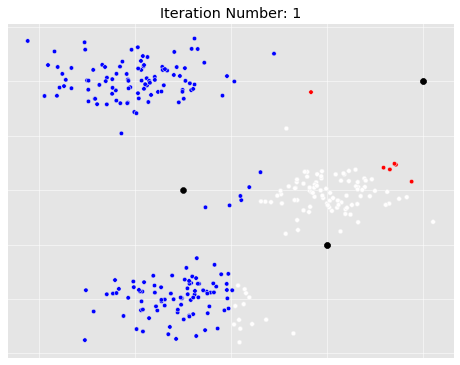

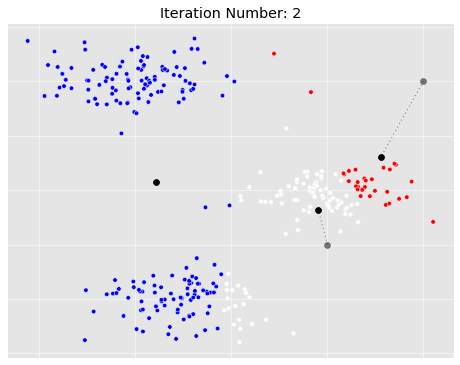

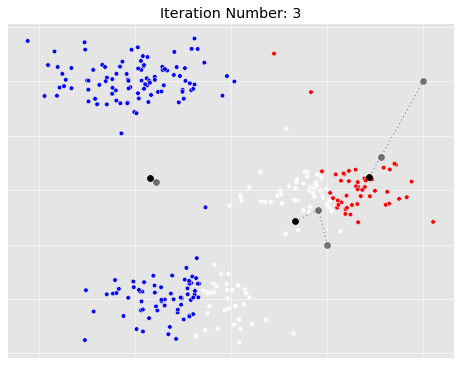

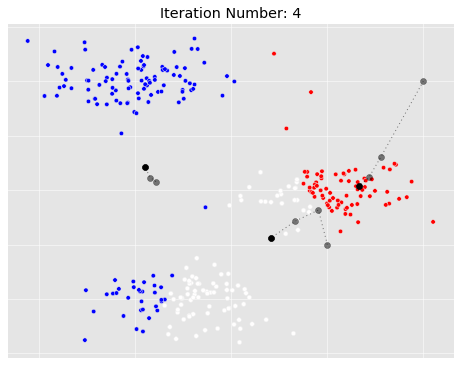

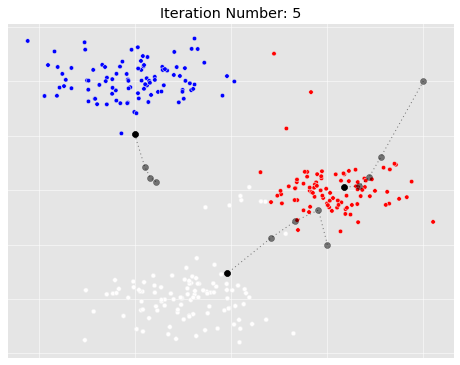

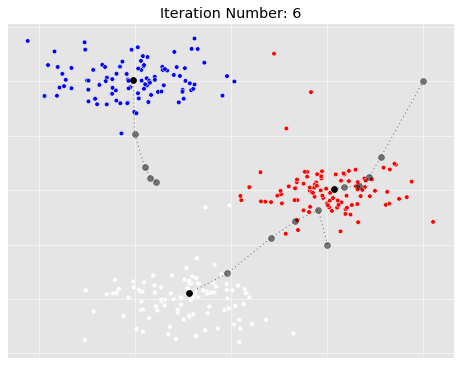

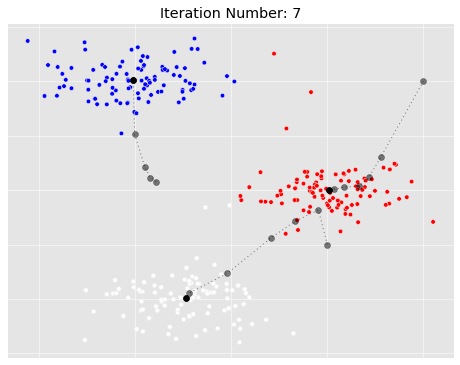

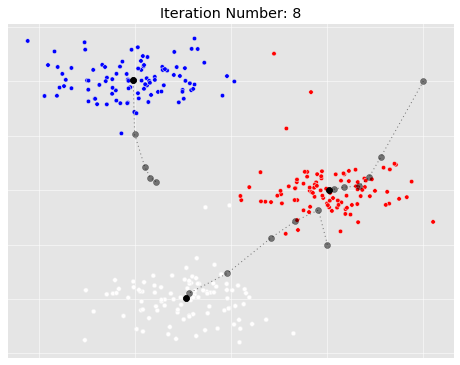

In [185]:
# loading the data
data = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex7-005\\mlclass-ex7\ex7data2.mat')
X = data['X']

K = 3 # 3 clusters
max_iters = 8 # setting max iterations of the algorithm at 8

# initializing centroids. This step needs to be randomized!
initial_centroids = np.array([[3, 3, 6, 2, 8, 5]]).reshape((3, 2))

centroids, idx = runkMeans(X, initial_centroids, max_iters, True)

### Image compression with *K*-means  

In this exercise, we will apply *K*-means to image compression. In a straightforward 24-bit color representation of an image, 1 each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, we will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, we only need to store the RGB values of the 16 selected colors, and for each pixel in the image we now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

We will use the *K*-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, we will treat every pixel in the original image as a data example and use the *K*-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once we have computed the cluster centroids on the image, we will then use the 16 colors to replace the pixels in the original image.

This is the image we need to compress.


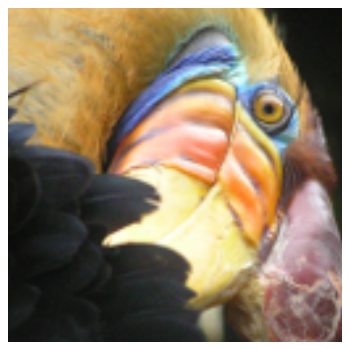

In [186]:
from skimage import io

bird = io.imread('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex7-005\\mlclass-ex7\\bird_small.png')

print('This is the image we need to compress.')

plt.imshow(bird)
plt.xticks(())
plt.yticks(())
plt.show()

As you can see the compressed image has a much lower resolution than the original one.
This is due to the fact that we are just using 16 colors to represent our exotic bird!


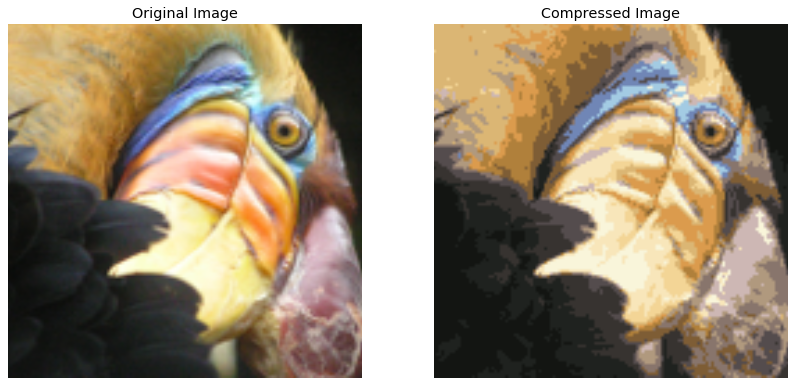

In [187]:
bird_original = io.imread('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex7-005\\mlclass-ex7\\bird_small.png')

# Divide by 255 so that all values are in the range 0 - 1
bird = bird_original/255

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on
bird = bird.reshape((bird.shape[0]*bird.shape[1], bird.shape[2]))

K = 16
max_iters = 10

# When using K-Means, it is important the initialize the centroids randomly
initial_centroids = kMeansInitCentroids(bird, K)

# running K-means
centroids, idx = runkMeans(bird, initial_centroids, max_iters)

bird_compressed = np.zeros((bird.shape[0], bird.shape[1]))

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by it's index in idx) to the centroid value
for i, cluster in enumerate(idx):
    bird_compressed[i,:] = centroids[int(cluster[0]) - 1,:]

# Reshape the recovered image into proper dimensions
bird_compressed = bird_compressed.reshape((bird_original.shape[0], bird_original.shape[1], bird_original.shape[2]))

print('As you can see the compressed image has a much lower resolution than the original one.')
print('This is due to the fact that we are just using 16 colors to represent our exotic bird!')

fig = plt.figure(figsize=(14, 8))

ax1 = fig.add_subplot(121)
ax1.imshow(bird_original)
ax1.set_title('Original Image')
plt.xticks(())
plt.yticks(())

ax2 = fig.add_subplot(122)
ax2.imshow(bird_compressed)
ax2.set_title('Compressed Image')
plt.xticks(())
plt.yticks(())

plt.show()